In [20]:
# Chuẩn bị môi trường
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # Chuẩn hóa dữ liệu
from sklearn.preprocessing import PowerTransformer # Biến đổi Box-Cox và Yeo-Johnson
from sklearn.model_selection import GridSearchCV


Hiển thị thông tin X ban đầu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None
Hiển thị 5 dòng đầu tiên của X:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0

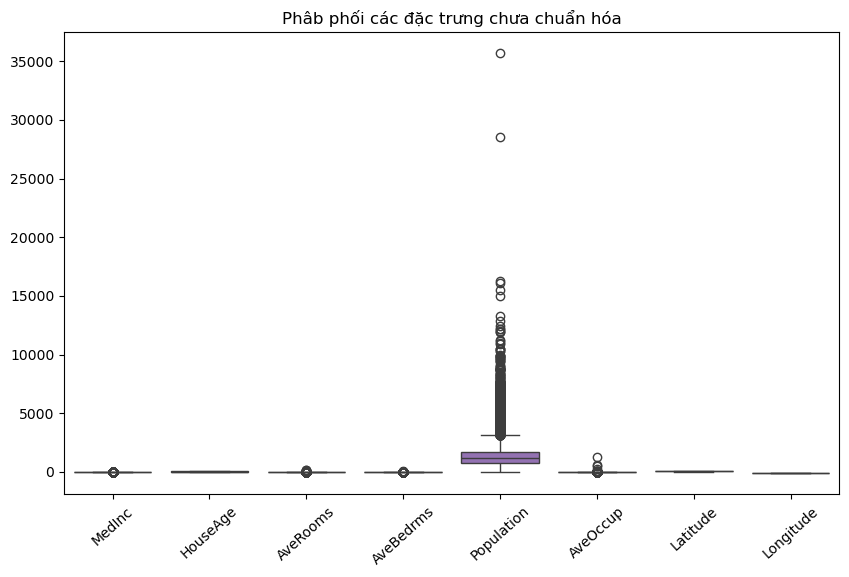

Kích thước dữ liệu ban đầu: (20640, 8)
Kích thước dữ liệu sau khi xử lý outliers: (16842, 8)


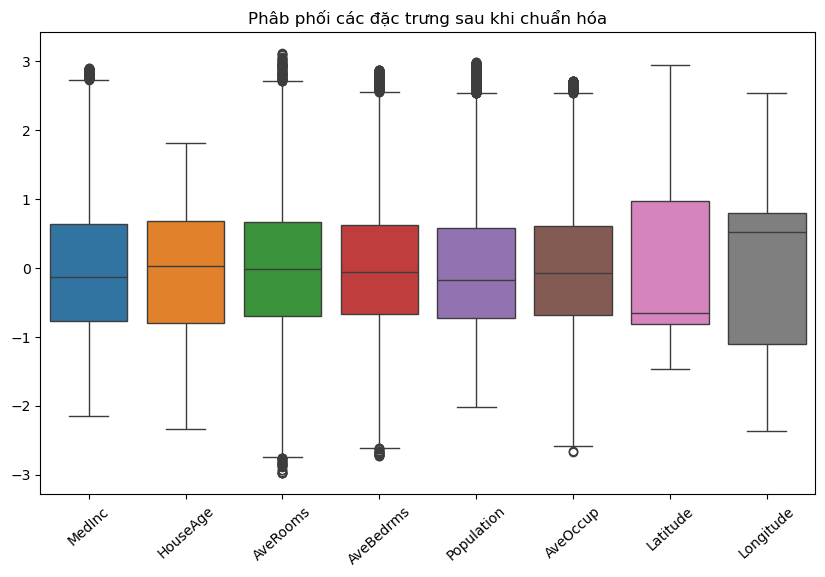

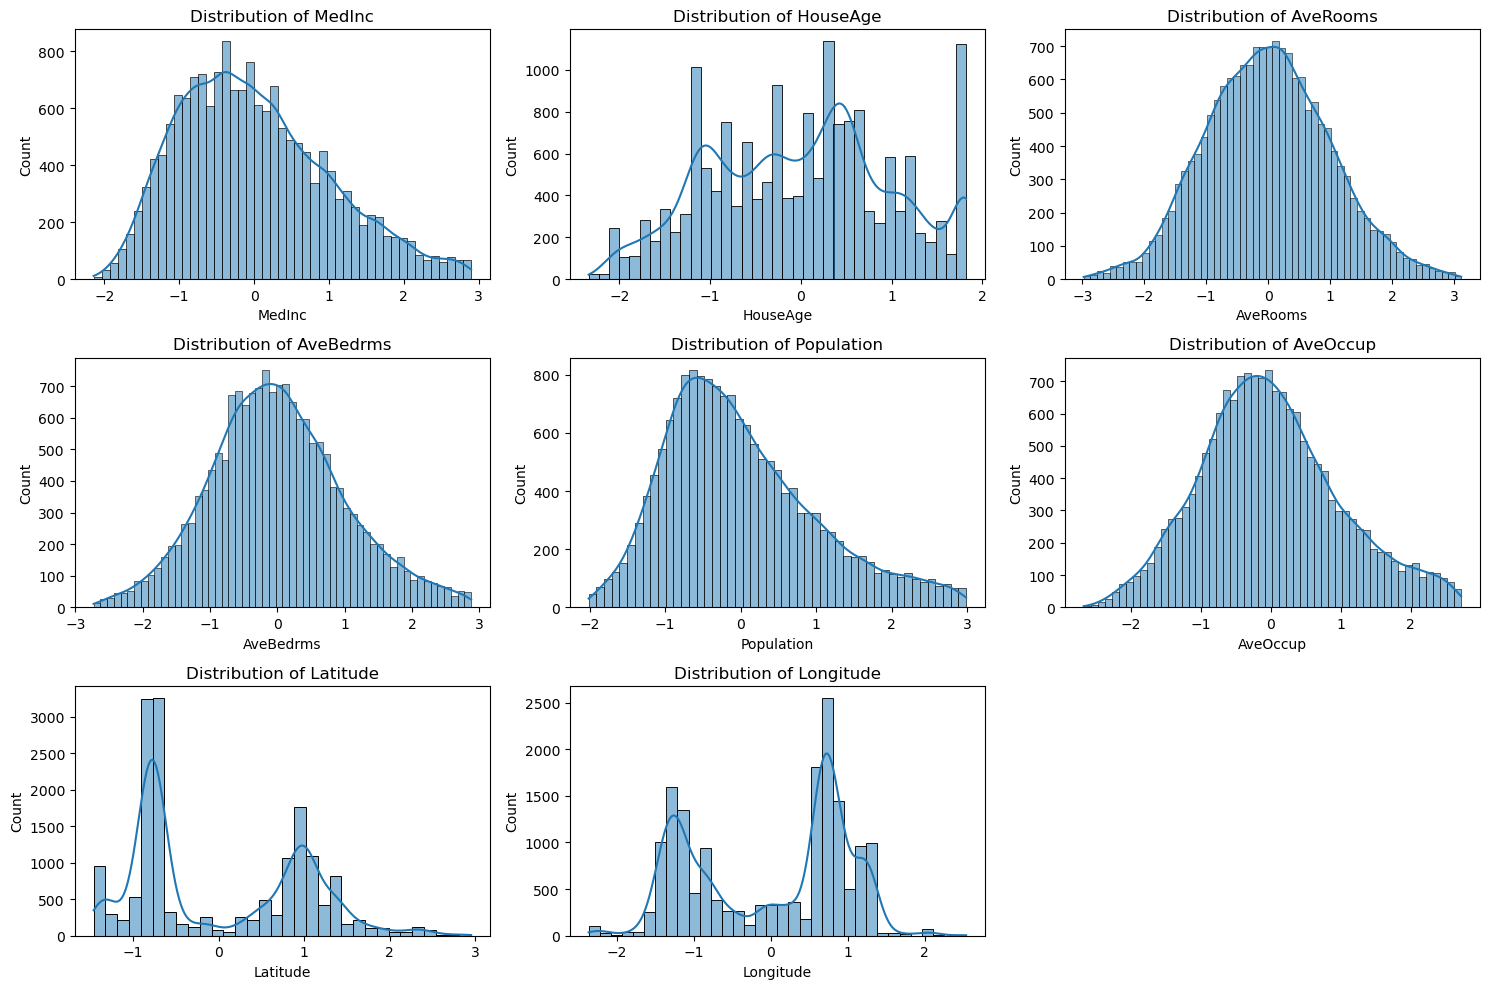

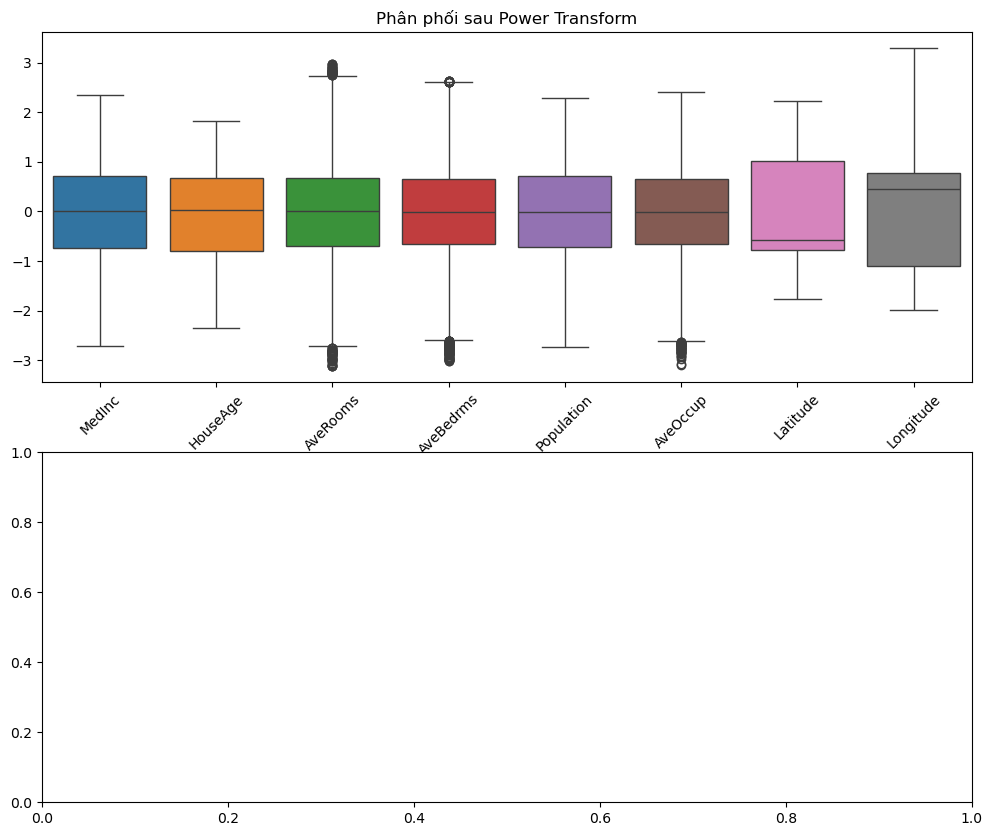

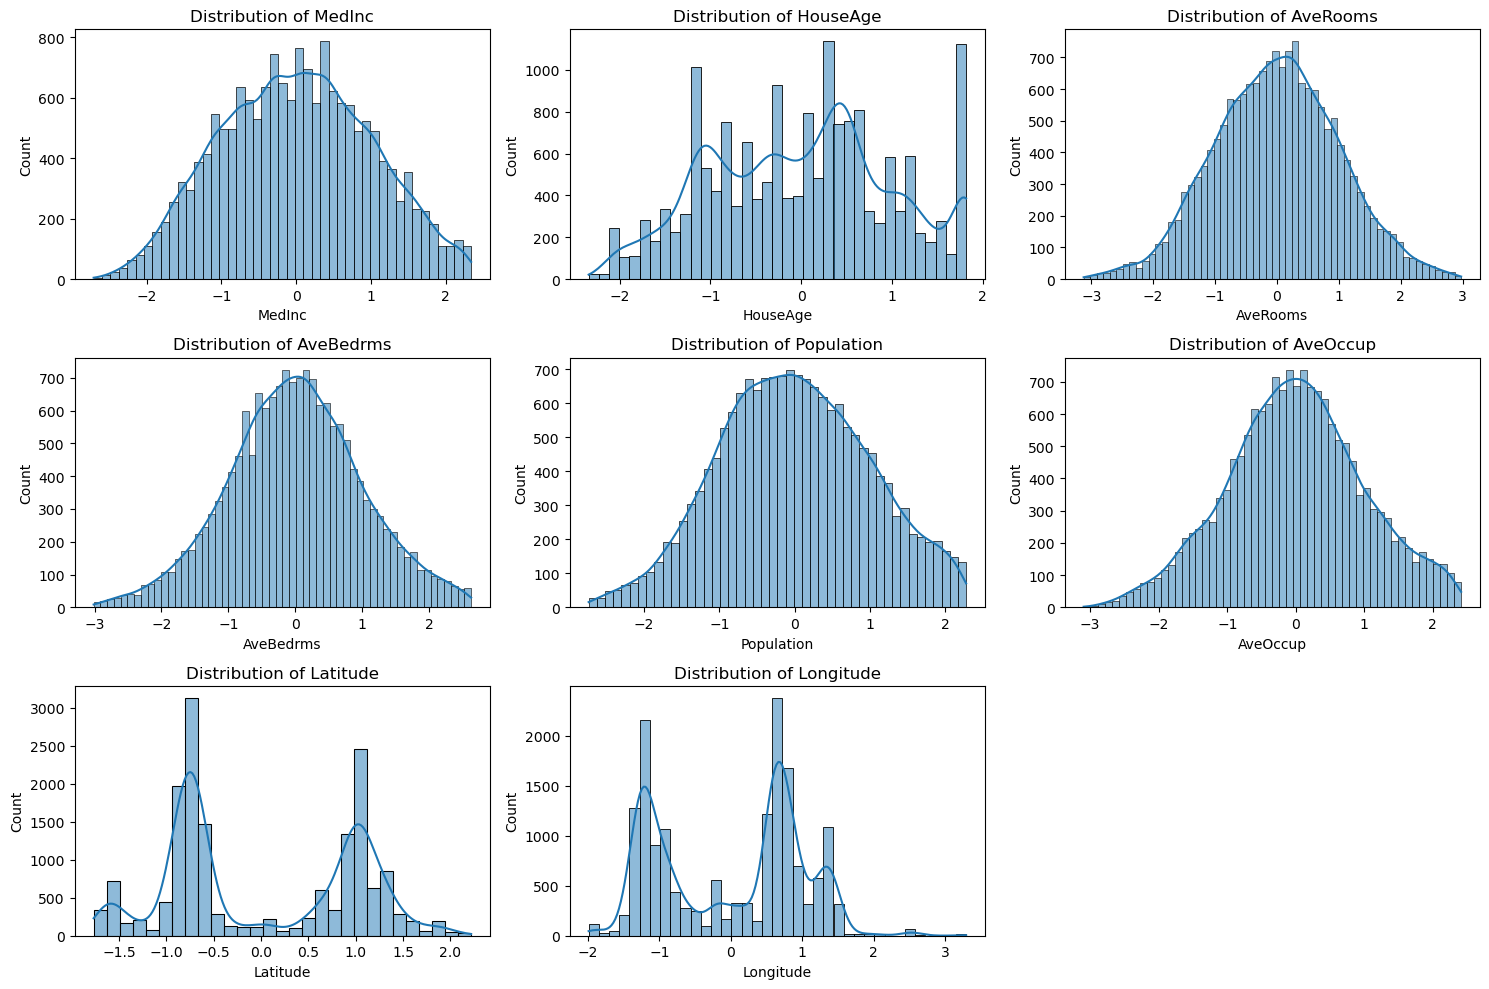


Độ lệch (skewness) sau transform:
MedInc        0.033221
HouseAge      0.006758
AveRooms      0.000898
AveBedrms    -0.010044
Population    0.017209
AveOccup     -0.008101
Latitude      0.140879
Longitude    -0.063887
dtype: float64


In [21]:
# Chuẩn bị bộ dữ liệu
X = pd.DataFrame(data=fetch_california_housing().data, columns=fetch_california_housing().feature_names)
y = pd.Series(data=fetch_california_housing().target)

X["MedHouseVal"] = y

print("Hiển thị thông tin X ban đầu:")
print(X.info())

print("Hiển thị 5 dòng đầu tiên của X:")
print(X.head())

print("Các dòng có gía trị null")
print(X.isnull().sum())

print("Các dòng có gía trị trùng lặp")
print(X.duplicated().sum())

y = X["MedHouseVal"]
X = X.drop(columns=["MedHouseVal"])

#Vẽ phân phối dữu liệu chưa chuẩn hóa
plt.figure(figsize=(10, 6))
sns.boxplot(data=X)
plt.title("Phâb phối các đặc trưng chưa chuẩn hóa")
plt.xticks(rotation=42)
plt.show()

# Phương pháp IQR để xác định và xử lý outliers
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

# Áp dụng xử lý outliers
X_clean = remove_outliers(X)
y_clean = y[X_clean.index]

print(f"Kích thước dữ liệu ban đầu: {X.shape}")
print(f"Kích thước dữ liệu sau khi xử lý outliers: {X_clean.shape}")

# Sử dụng StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_clean), columns=X.columns)


#Vẽ phân phối dữu liệu
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_scaled)
plt.title("Phâb phối các đặc trưng sau khi chuẩn hóa")
plt.xticks(rotation=42)
plt.show()

# Kiểm tra phân phối chi tiết của từng đặc trưng
plt.figure(figsize=(15, 10))
for i, column in enumerate(X_scaled.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(X_scaled[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# Áp dụng Power Transform
power = PowerTransformer(method='yeo-johnson')
X_transformed = pd.DataFrame(
    power.fit_transform(X_scaled),
    columns=X_scaled.columns
)

# Vẽ lại biểu đồ sau transform
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Boxplot
sns.boxplot(data=X_transformed, ax=ax1)
ax1.set_title("Phân phối sau Power Transform")
ax1.tick_params(axis='x', rotation=45)

# Histogram matrix
plt.figure(figsize=(15, 10))
for i, column in enumerate(X_transformed.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(X_transformed[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# In thống kê độ lệch
print("\nĐộ lệch (skewness) sau transform:")
print(X_transformed.skew())

In [22]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, y_clean, test_size=0.2, random_state=42)

print(f"Kích thước tập huấn luyện: {X_train.shape}, Kích thước tập kiểm tra: {X_test.shape}")

Kích thước tập huấn luyện: (13473, 8), Kích thước tập kiểm tra: (3369, 8)


In [23]:
from sklearn.model_selection import GridSearchCV

# Định nghĩa lưới tham số
tham_so = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Tìm kiếm lưới
tim_kiem = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    tham_so,
    cv=5,
    scoring='r2'
)

# Huấn luyện
tim_kiem.fit(X_train, Y_train)
mo_hinh_tot_nhat = tim_kiem.best_estimator_

# Đánh giá
Y_du_doan = mo_hinh_tot_nhat.predict(X_test)
print(f"Điểm R2 với tham số tối ưu: {r2_score(Y_test, Y_du_doan)}")
print(f"Tham số tốt nhất: {tim_kiem.best_params_}")

Điểm R2 với tham số tối ưu: 0.6876777342347581
Tham số tốt nhất: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [24]:
# đánh giá
Y_pred = mo_hinh_tot_nhat.predict(X_test)
print(f"R2 score: {r2_score(Y_test, Y_pred)}")

R2 score: 0.6876777342347581


In [25]:
# Dự đoán
new_data = pd.DataFrame({
    'MedInc': [8.3252],
    'HouseAge': [41.0],
    'AveRooms': [6.984127],
    'AveBedrms': [1.02381],
    'Population': [322.0],
    'AveOccup': [2.555556],
    'Latitude': [37.88],
    'Longitude': [-122.23]
}) 
predicted_value = mo_hinh_tot_nhat.predict(new_data)
print(f"Giá nhà dự đoán: {predicted_value[0]}")


Giá nhà dự đoán: 3.716875


In [26]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)
rf_pred = rf_model.predict(X_test)
print(f"Điểm R2 của Random Forest: {r2_score(Y_test, rf_pred)}")

Điểm R2 của Random Forest: 0.7806424022807994
